## F05) Visual motion analysis of the player’s finger
Paesano Emanuele, Hu Alessio

Try to extract the motion of fingers (in their three articulations) of keyboard player from a video sequence. Instruments with a keyboard can include accordion, piano, organ, bandoneon etc.

### Import libraries

In [13]:
import numpy as np
import cv2
import json
import utils as utils

## Piano in static position

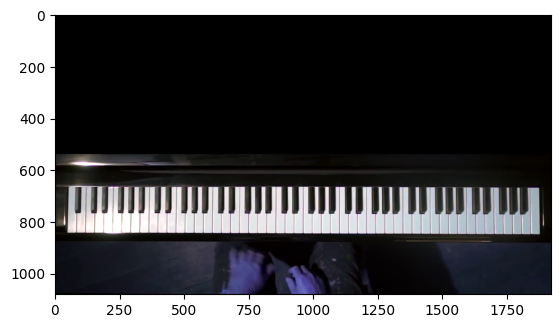

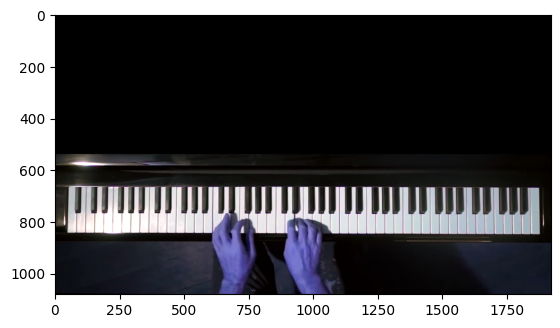

In [14]:
video = "videos/piano/covered_bolero.mp4"
cap = cv2.VideoCapture(video)
fps = np.ceil(cap.get(cv2.CAP_PROP_FPS))
frame_keyboard = utils.extractFrames(video, start_time=6, end_time=6+1/fps)[0]
frame_hand = utils.extractFrames(video, start_time=32, end_time=32+1/fps)[0]

# video = "videos/piano/bach_toccata_and_fugue.mp4"
# cap = cv2.VideoCapture(video)
# fps = np.ceil(cap.get(cv2.CAP_PROP_FPS))
# frame_keyboard = utils.extractFrames(video, start_time=8.4, end_time=8.4+1/fps)[0]
# frame_hand = utils.extractFrames(video, start_time=32, end_time=32+1/fps)[0]

utils.plotImg(frame_keyboard)
utils.plotImg(frame_hand)

In [15]:
utils.playVideo(video,
            start_time=17,
            end_time=188.01)

430.0/4512.24
17.916666666666668/188.01


### Hands and keyboard masks

[120  75   0]
[255 255 255]


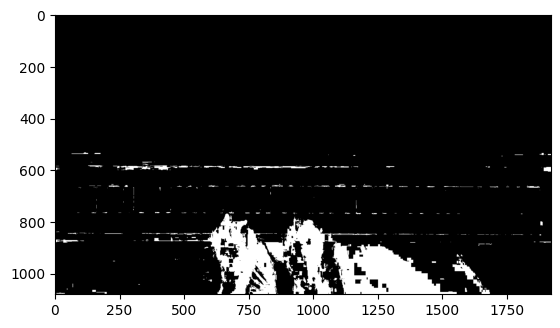

In [ ]:
# Hand mask ranges, TAKE WITH SHADOWS
cv2.destroyAllWindows()
lower_hand_thresh, upper_hand_thresh, mask_hand = utils.segmentationMaskTuning(frame_hand)
print(lower_hand_thresh)
print(upper_hand_thresh)
utils.plotImg(mask_hand,'gray')

[  0   0 178]
[217 255 255]


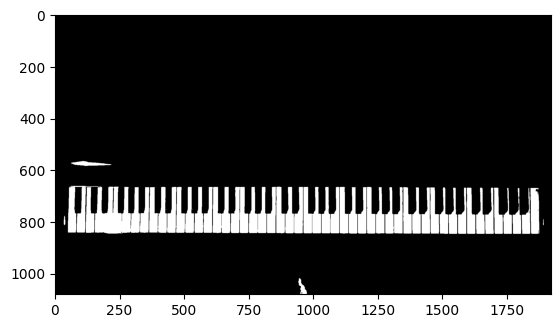

In [ ]:
# Keyboard mask ranges
cv2.destroyAllWindows()
lower_keyboard_thresh, upper_keyboard_thresh, mask_keyboard = utils.segmentationMaskTuning(frame_keyboard)
print(lower_keyboard_thresh)
print(upper_keyboard_thresh)
utils.plotImg(mask_keyboard,'gray')


In [ ]:
cv2.destroyAllWindows()
utils.playVideo(video,
            start_time=17,
            end_time=188.01,
            callback=utils.segmentationInRange,
            #callback_args=[lower_hand_thresh, upper_hand_thresh, False])
            callback_args=[lower_keyboard_thresh, upper_keyboard_thresh, False])

424.0/4512.24
17.666666666666668/188.01


Some precomputed masks for "covered_bolero.mp4", obtained from the manual method

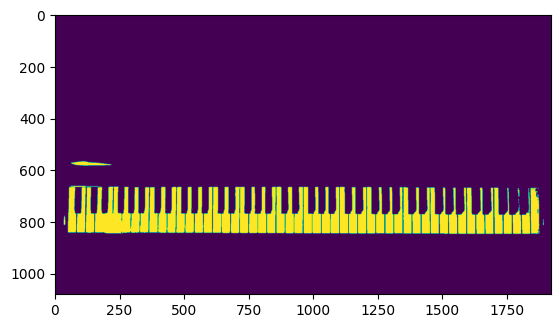

In [ ]:
# some default for testing for bolero
# hand with shadows mask
lower_hand_thresh = np.array([ 0, 47, 69])
upper_hand_thresh = np.array([255, 251, 254])

# keyboard mask
lower_keyboard_thresh = np.array([  0,   0, 180])
upper_keyboard_thresh = np.array([255,  68, 255])
mask_keyboard = utils.segmentationInRange(frame_keyboard,lower_keyboard_thresh,upper_keyboard_thresh,show=False)
utils.plotImg(mask_keyboard)


# some default for testing for bach
# hand with shadows mask
#lower_hand_thresh = np.array([ 0, 24, 59])
#upper_hand_thresh = np.array([192, 90, 157])
#
## keyboard mask
#lower_keyboard_thresh = np.array([ 0, 0, 131])
#upper_keyboard_thresh = np.array([136, 74, 255])

#mask_keyboard = utils.segmentationInRange(frame_keyboard,lower_keyboard_thresh,upper_keyboard_thresh,show=False)
#utils.plotImg(mask_keyboard)

### Keyboard rectification

#### Automatic

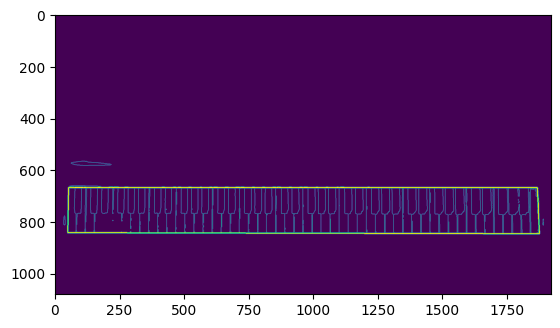

array([[ 1.05479371e+00,  2.00151303e-02, -1.49730745e+01],
       [ 8.64612287e-03,  1.07784183e+00, -3.62340845e+01],
       [ 1.29239505e-05,  3.53965170e-05,  1.00000000e+00]])

In [ ]:
# Find the rectifying matrix H_shape
H_shape, pts1, pts2, keyboard_shape = utils.getRectifyingMatrix(frame_keyboard,lower_keyboard_thresh,upper_keyboard_thresh)
H_shape

#### Manual

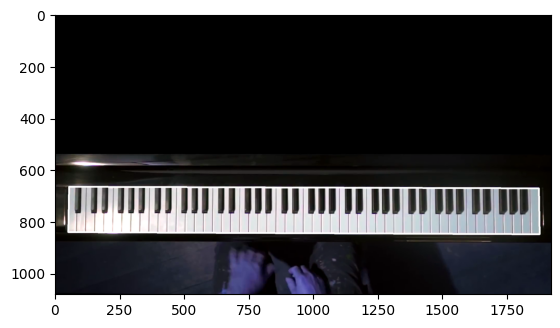

array([[ 1.02817145e+00,  1.86534306e-02, -1.32380266e+01],
       [ 7.51794692e-04,  1.04071527e+00, -1.84444934e+01],
       [ 6.23129508e-06,  1.91370864e-05,  1.00000000e+00]])

In [ ]:
# take the points counter-clock wise!!!
H_shape, pts1, pts2, keyboard_shape = utils.getRectifyingMatrixManual(frame_keyboard)
H_shape

#### Play rectified video

In [1]:
# rotation matrix
R = np.eye(3)
keyboard_height, keyboard_width = keyboard_shape
if keyboard_width > keyboard_height:
    top_left = pts2[0]
    center = (keyboard_width/2+top_left[0], keyboard_height/2+top_left[1])
    rotation_angle = 90 #to have horizontal keyboard
    R = cv2.getRotationMatrix2D(center, rotation_angle, 1) #2x3
    R = np.append(R,[[0,0,1]], axis=0) #3x3

cv2.destroyAllWindows()
utils.playVideo(video,
            start_time=27,
            end_time=188.01,
            callback=utils.rectifyWithMatrix,
            callback_args=[lower_keyboard_thresh, upper_keyboard_thresh, H_shape, R],
            save_video=False, video_name="", video_size=(1920+192,1080+108))
            #callback_args=[lower_keyboard, upper_keyboard, H_shape, pts2, keyboard_shape])


NameError: name 'np' is not defined

### Keys regions retrieval

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


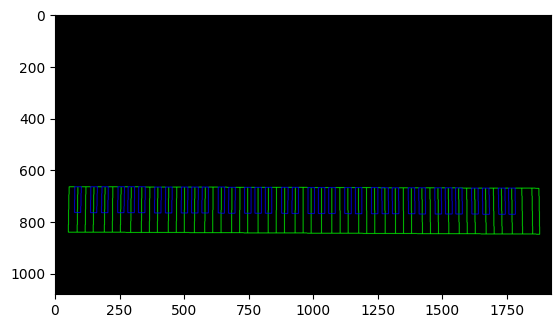

In [12]:
# Find the keys regions
keys = utils.getKeyboardContour(frame_keyboard, lower_keyboard_thresh, upper_keyboard_thresh, pts2, H_shape, keyboard_shape)
color = (0,255,0)
frame_tmp = np.zeros((1080,1920,3))
for black in keys["white"]:
    cv2.drawContours(frame_tmp, black["contour"], -1, (0, 255, 0), thickness=2)
for black in keys["black"]:
    cv2.drawContours(frame_tmp, black["contour"], -1, (0, 0, 255), thickness=2)
utils.plotImg(frame_tmp, "gray")

### Pressed keys detection

In [16]:
# load the key_id <-> key_midi_id mapping
white_keys_map = None
black_keys_map = None
with open("keys_map.json", "r") as fp:
    obj = json.load(fp)
    white_keys_map = obj["white_keys_map"]
    black_keys_map = obj["black_keys_map"]

In [ ]:
def detectPressedKeysCallback(frame,
        lower_keyboard_thresh, upper_keyboard_thresh,
        lower_hand_thresh, upper_hand_thresh,
        mask_keyboard,
        keys, white_keys_map, black_keys_map,
        final_notes, stop_point=None):

    functions = [
        {"function": utils.segmentationInRange, "args": [frame, lower_hand_thresh, upper_hand_thresh, False]},
        {"function": utils.segmentationInRange, "args": [frame, lower_keyboard_thresh, upper_keyboard_thresh, False]}
    ]
    results = [None]*len(functions)
    utils.threadMultiple(functions, results)
    mask_hand, cur_frame_segmented = results
    
    return utils.detectPressedKeys(frame,
        cur_frame_segmented, mask_hand,
        mask_keyboard,
        keys, white_keys_map, black_keys_map,
        final_notes, stop_point)


# stop_point for detectPressedKeys, to see intermediate steps
stop_point = [
    None,
    "shadows_white",
    "shadows_black",
    "hough_white",
    "hough_black",
]

# list to store pressed keys
final_notes = []

cv2.destroyAllWindows()
utils.playVideo(video,
            start_time=8, #114.5,#27,
            end_time=5*60+40,#188,
            frames_every=1,
            callback=detectPressedKeysCallback,
            callback_args=[
                lower_keyboard_thresh, upper_keyboard_thresh,
                lower_hand_thresh, upper_hand_thresh,
                mask_keyboard,
                keys, white_keys_map, black_keys_map,
                final_notes, stop_point[0]],
            save_video=False, video_name="output.mp4", video_size=(1920,1080))
            #callback_args=[lower_keyboard, upper_keyboard, H_shape, pts2, keyboard_shape])

200.0/8160.0
8.333333333333334/340
1080 =?= 1080, 1920 =?= 1920


In [ ]:
# save the keys to a json file
with open(video.replace("mp4","json"), "w") as fp:
    json.dump(final_notes, fp, indent = 4)

### Generate MIDI file

In [41]:
with open("final_results/covered_bolero.json", "r") as fp:
    final_notes = json.load(fp)
utils.generateMidiFile(final_notes, "covered_bolero_slow.mid", fps)

In [38]:
# load keys from json file if needed
with open(video.replace("mp4","json"), "r") as fp:
    final_notes = json.load(fp)

In [39]:
title = video.replace("mp4","mid").replace("mkv","mid")
print(title)
utils.generateMidiFile(final_notes, title, fps)

videos/piano/bach_toccata_and_fugue.mid


## Static Piano with UNet Segmentation

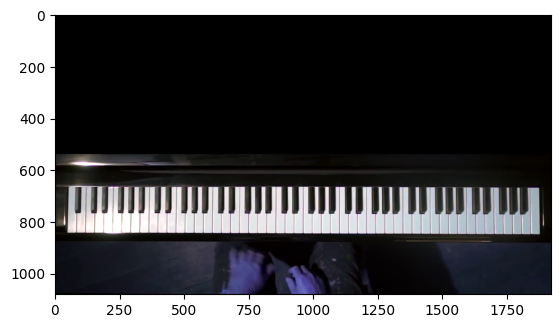

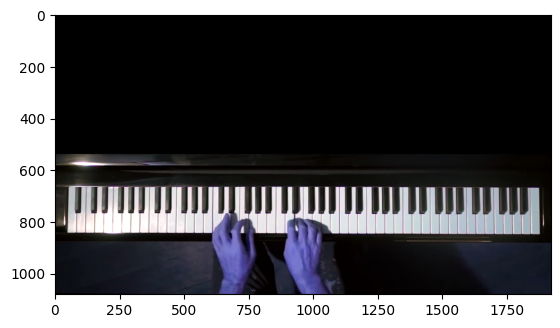

In [18]:
video = "videos/piano/covered_bolero.mp4"
cap = cv2.VideoCapture(video)
fps = np.ceil(cap.get(cv2.CAP_PROP_FPS))
frame_keyboard = utils.extractFrames(video, start_time=6, end_time=6+1/fps)[0]
frame_hand = utils.extractFrames(video, start_time=32, end_time=32+1/fps)[0]

# video = "videos/piano/bach_toccata_and_fugue.mp4"
# cap = cv2.VideoCapture(video)
# fps = np.ceil(cap.get(cv2.CAP_PROP_FPS))
# frame_keyboard = utils.extractFrames(video, start_time=8.4, end_time=8.4+1/fps)[0]
# frame_hand = utils.extractFrames(video, start_time=32, end_time=32+1/fps)[0]


utils.plotImg(frame_keyboard)
utils.plotImg(frame_hand)

### Load the model and define functions

In [19]:
# load the model
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers

# Unet
model = tfk.models.load_model('segmentation/UNet_3_classes', custom_objects={'UpdatedMeanIoU': tf.keras.metrics.MeanIoU})

In [20]:
def unetSegmentation(frame, model):
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    h, w, _ = frame_bgr.shape
    resized = cv2.resize(frame_bgr, (256, 144)) / 255.
    pred = model.predict(np.expand_dims(resized, axis=0), verbose=0)
    pred = np.array(tf.math.argmax(pred, axis=-1))
    pred = np.reshape(pred, (144, 256, 1))
    # 0 is null, 1 is hand, 2 is keyboard

    def getMask(class_id):
        mask = pred.copy().astype(np.uint8)
        mask = cv2.resize(mask, (w, h))
        mask[mask != class_id] = 0
        mask[mask == class_id] = 255
        return mask
        
    functions = [
        {"function": getMask, "args": [1]},
        {"function": getMask, "args": [2]}
    ]

    results = [None]*len(functions)
    utils.threadMultiple(functions, results)
    cur_mask_hand, cur_mask_keyboard = results
    return cur_mask_hand, cur_mask_keyboard

def unetSegmentationSubCrops(frame, model):
    # the network works with BGR images only!!
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    def predictCrop(cur_mask_hand, cur_mask_keyboard, x, y, x_step, y_step):
        crop = frame_bgr[y-y_step:y,x-x_step:x]
        resized = cv2.resize(crop, (256, 144)) / 255.
        pred = model.predict(np.expand_dims(resized, axis=0), verbose=0)
        pred = np.array(tf.math.argmax(pred, axis=-1))
        pred = np.reshape(pred, (144, 256))

        mask = pred.copy().astype(np.uint8)
        mask = cv2.resize(mask, (x_step, y_step))
        class_id = 1
        mask[mask != class_id] = 0
        mask[mask == class_id] = 255
        cur_mask_hand[y-y_step:y,x-x_step:x] = mask

        mask = pred.copy().astype(np.uint8)
        mask = cv2.resize(mask, (x_step, y_step))
        class_id = 2
        mask[mask != class_id] = 0
        mask[mask == class_id] = 255
        cur_mask_keyboard[y-y_step:y,x-x_step:x] = mask

    cur_mask_hand = np.zeros(frame.shape[0:2], dtype=np.uint8) # frame_bgr
    cur_mask_keyboard = np.zeros(frame.shape[0:2], dtype=np.uint8) # frame_bgr
    functions = []
    x_step = 960 #256
    y_step = 540 #144
    x = x_step
    while x <= 1920:
        y = y_step
        while y <= 1080:
            functions.append({"function": predictCrop, "args": [cur_mask_hand, cur_mask_keyboard, x, y, x_step, y_step]})
            y += y_step
        x += x_step
    results = [None]*len(functions)
    utils.threadMultiple(functions, results)
    return cur_mask_hand, cur_mask_keyboard

### Keyboard rectification

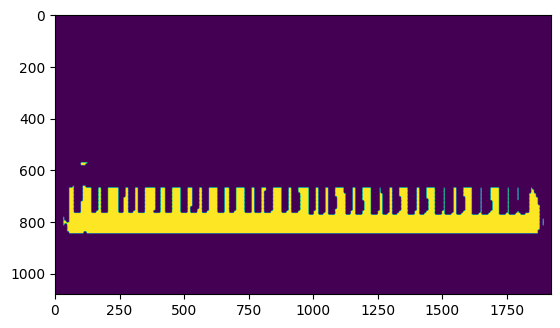

In [21]:
_, unet_mask_keyboard = unetSegmentation(frame_keyboard, model)
# unet_mask_keyboard = cv2.bitwise_and(unet_mask_keyboard, cv2.cvtColor(frame_keyboard, cv2.COLOR_BGR2GRAY))
utils.plotImg(unet_mask_keyboard)

#### Automatic

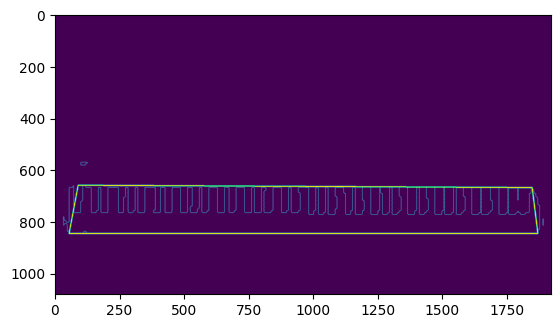

In [22]:
# Find the rectifying matrix H_shape
H_shape, pts1, pts2, keyboard_shape = utils.getRectifyingMatrix(unet_mask_keyboard,None,None,processed=True)

#### Manual

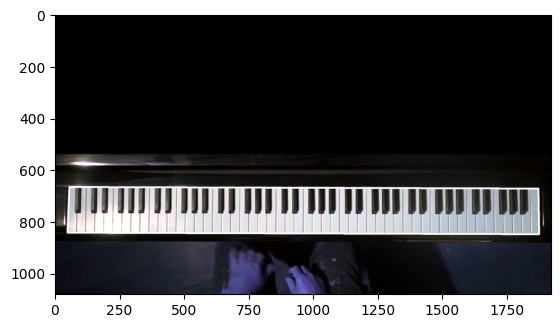

array([[ 1.02664285e+00,  4.25939116e-02, -2.87015067e+01],
       [-3.54120883e-03,  1.04820380e+00, -1.77198778e+01],
       [-2.11474527e-07,  3.20193243e-05,  1.00000000e+00]])

In [23]:
# take the points counter-clock wise!!!
H_shape, pts1, pts2, keyboard_shape = utils.getRectifyingMatrixManual(frame_keyboard)
H_shape

#### Play rectified video

In [24]:
# rotation matrix
R = np.eye(3)
keyboard_height, keyboard_width = keyboard_shape
if keyboard_width > keyboard_height:
    top_left = pts2[0]
    center = (keyboard_width/2+top_left[0], keyboard_height/2+top_left[1])
    rotation_angle = 90 #to have horizontal keyboard
    R = cv2.getRotationMatrix2D(center, rotation_angle, 1) #2x3
    R = np.append(R,[[0,0,1]], axis=0) #3x3

cv2.destroyAllWindows()
utils.playVideo(video,
            start_time=27,
            end_time=188.01,
            callback=utils.rectifyWithMatrix,
            callback_args=[None, None, H_shape, R],
            save_video=False, video_name="", video_size=(1920+192,1080+108))
            #callback_args=[lower_keyboard, upper_keyboard, H_shape, pts2, keyboard_shape])

666.0/4512.24
27.75/188.01


### Keys regions retrieval

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


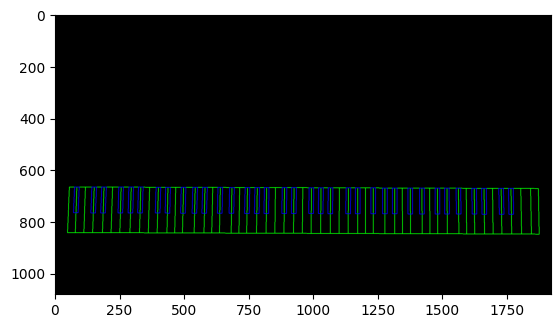

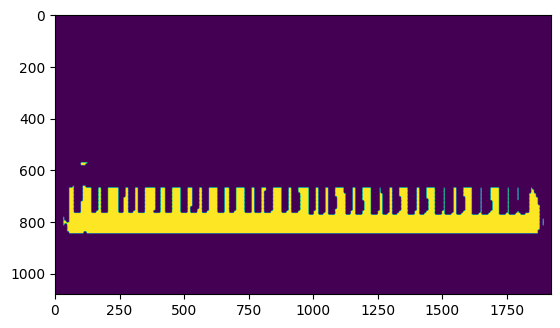

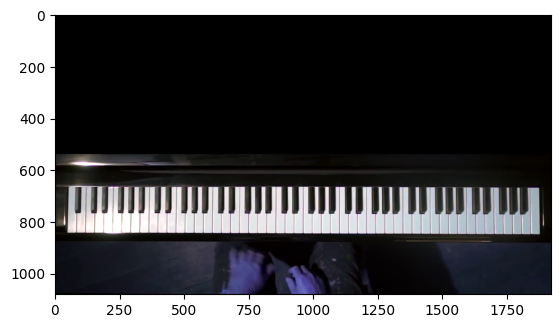

In [25]:
# Find the keys regions
keys = utils.getKeyboardContour(frame_keyboard, None, None, pts2, H_shape, keyboard_shape, frame_segmented=unet_mask_keyboard)
color = (0,255,0)
frame_tmp = np.zeros((1080,1920,3))
for black in keys["white"]:
    cv2.drawContours(frame_tmp, black["contour"], -1, (0, 255, 0), thickness=2)
for black in keys["black"]:
    cv2.drawContours(frame_tmp, black["contour"], -1, (0, 0, 255), thickness=2)
utils.plotImg(frame_tmp, "gray")
utils.plotImg(unet_mask_keyboard)
utils.plotImg(frame_keyboard)

### Pressed keys detection

In [26]:
# load the key_id <-> key_midi_id mapping
white_keys_map = None
black_keys_map = None
with open("keys_map.json", "r") as fp:
    obj = json.load(fp)
    white_keys_map = obj["white_keys_map"]
    black_keys_map = obj["black_keys_map"]

In [27]:
# _, unet_mask_keyboard = unetSegmentationSubCrops(frame_keyboard, model)

# define the callback
def unetSegmentationCallback(frame, model, mask_keyboard,
                             keys, white_keys_map, black_keys_map,
                             final_notes, stop_point):
    # the network works with BGR images only!!
    # cur_mask_hand, cur_mask_keyboard = unetSegmentation(frame, model)
    cur_mask_hand, cur_mask_keyboard = unetSegmentationSubCrops(frame, model)

    return utils.detectPressedKeys(frame,
        cur_mask_keyboard, cur_mask_hand,
        mask_keyboard,
        keys, white_keys_map, black_keys_map,
        final_notes, stop_point)

# stop_point for detectPrssedKeysUnet, to see intermediate steps
stop_point = [
    None,
    "shadows_white",
    "shadows_black",
    "hough_white",
    "hough_black",
]

# list to store pressed keys
final_notes = []

cv2.destroyAllWindows()
utils.playVideo(video,
            start_time=17,
            end_time=188.01,
            frames_every=1,
            callback=unetSegmentationCallback,
            callback_args=[
                model, unet_mask_keyboard,
                keys, white_keys_map, black_keys_map,
                final_notes, stop_point[0]],
            save_video=True, video_name="unet.mp4", video_size=(1920,1080))#, t_mean])

418.0/4512.24
17.416666666666668/188.01
1080 =?= 1080, 1920 =?= 1920


In [ ]:
# save the keys to a json file
with open("unet"+video.replace("mp4","json"), "w") as fp:
    json.dump(final_notes, fp, indent = 4)

### Generate MIDI file

In [177]:
with open("unet_"+video.replace("mp4","json"), "r") as fp:
    final_notes = json.load(fp)

FileNotFoundError: [Errno 2] No such file or directory: 'unetvideos/piano/covered_bolero.json'

In [181]:
title = video.replace("mp4","mid").replace("mkv","mid")
print(title)
utils.generateMidiFile(final_notes, title, fps)

videos/piano/covered_bolero.mid
